### Taxi Cab Fare  

The goal of this project is predict the tip amount paid for a a taxi ride in NYC in 2015.  The main technical challenge in this project is the size of the data set:  77106102 observations!  This is obviously too much data to simply download locally and load into memora via a pandas dataframe, so in this project I focus less on the typical model building techniques like data cleaning and parameter tuning and more on exploring the technologies needed to manipulate and explore such a large data set.  

For this project I created an Apache Spark cluster consisting of 1 master node and 4 worker nodes on the Google Cloud Plaform (GCP).  Apache Spark is an open source platform for fast analytics on large datasets and fortunately a Python API (PySpark) exists.  The core principal of Spark is the notion of Resilient Distributed Datasets (RDD).  In the Spark framework a dataset is divided into RDDs and distributed to different compute nodes on a cluster, allowing us to essentially partition and apply operations on a dataset over a cluster size of our choice.   

After setting up a GCP account (thanks for the free $300 trial!) a PySpark cluster was created by running the following command locally:

In [ ]:
gcloud dataproc clusters create cluster_name \
    --num-workers 4 --worker-machine-type n1-standard-1 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-size 128 \
    --worker-boot-disk-size 128 \
    --scopes 'https://www.googleapis.com/auth/cloud-platform' \
    --project thaddeus \
    --metadata="MINICONDA_VARIANT=2" \
    --initialization-actions \
        gs://dataproc-initialization-actions/jupyter/jupyter.sh

Next, I created a ssh tunnel to the cluster:  

In [ ]:
gcloud compute ssh cluster_name-m -- -D 10000 -N -n

An connected via my browser:

In [ ]:
/Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome "http://cluster_name-m:8123" \
--proxy-server="socks5://localhost:10000" \
--host-resolver-rules="MAP * 0.0.0.0 , EXCLUDE localhost" \
--user-data-dir=/tmp/

And with that, we are ready to start analyzing the taxi dataset.

In [1]:
from pyspark.sql.functions import mean, min as smin, max as smax, udf, date_format
from pyspark.sql.types import TimestampType, StringType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import time
import pyspark.ml.regression
from pyspark.ml.linalg import Vectors

In [13]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

### Load the Data

In [2]:
# load the dataset from the datasci-450 bucket
start_time = time.time()
storage_url = 'gs://datasci-450/resources/datasets/taxi/*'
taxi = spark.read.format('csv').load(storage_url, header=True, inferSchema=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 227.490402937 seconds ---


In [15]:
# determine the number of rows in the spark DF
print 'number of rows:  ', taxi.count()

number of rows:   77106102


In [8]:
# holy smokes, that is a lot of rows.  next, take a look at the df
taxi.show(3)

+---------+--------------------+--------------------+------------------+------------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+
|vendor_id|     pickup_datetime|    dropoff_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|rate_code|passenger_count|trip_distance|payment_type|fare_amount|extra|mta_tax|imp_surcharge|tip_amount|tolls_amount|total_amount|store_and_fwd_flag|
+---------+--------------------+--------------------+------------------+------------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+
|      CMT|2015-04-30 16:30:...|2015-04-30 17:41:...|-73.78235626220703| 40.64461135864258|-73.88793182373047|40.874080657958984|        1|              1|        

In [11]:
# determine what features are in the df
taxi.columns

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'rate_code',
 'passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'imp_surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'store_and_fwd_flag']

In [7]:
# check the data types
taxi.printSchema()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)



### Exploratory Data Analysis

In [ ]:
# we will take a snippet of the data for exploration. 
start_time = time.time()

taxi_sample = taxi.sample(withReplacement=False, fraction=0.005, seed=123)
taxi_pd = taxi_sample.toPandas()

print '# of columns:  ', taxi_pd.shape[0]
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
# write this pd to disk in case i get booted
taxi_pd.to_csv('taxi_pd.csv')

In [17]:
taxi_pd.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,CMT,2015-02-12 11:35:16 UTC,2015-02-12 12:10:59 UTC,-74.004471,40.725513,-73.980072,40.752544,1,1,3.10,CRD,22.0,0.0,0.5,0.3,5.70,0.00,28.50,N
1,VTS,2015-03-19 21:26:04 UTC,2015-03-19 21:54:44 UTC,-73.994011,40.720161,-73.956444,40.784092,1,1,6.63,CRD,24.0,0.5,0.5,0.3,5.06,0.00,30.36,N
2,VTS,2015-03-12 22:04:42 UTC,2015-03-12 22:31:04 UTC,-73.976700,40.749256,-74.000793,40.676086,1,1,8.73,CRD,28.0,0.5,0.5,0.3,7.32,0.00,36.62,N
3,VTS,2015-05-27 16:52:32 UTC,2015-05-27 17:34:35 UTC,-73.975441,40.750584,-73.864929,40.770416,1,1,11.21,CRD,35.5,1.0,0.5,0.3,8.57,5.54,51.41,N
4,CMT,2015-06-21 10:24:20 UTC,2015-06-21 10:48:44 UTC,-73.963249,40.799080,-73.998734,40.734768,1,1,6.40,CRD,23.0,0.0,0.5,0.3,2.30,0.00,26.10,N


In [92]:
# start with tip_amount
taxi_pd['tip_amount'].describe()

count    384373.000000
mean          1.674335
std           2.573321
min          -2.700000
25%           0.000000
50%           1.150000
75%           2.260000
max         436.750000
Name: tip_amount, dtype: float64

In [65]:
# how can there be a negative tip?  moving on....
# how many vendor IDs are there?
print 'unique vendor IDs:  ', len(taxi_pd['vendor_id'].unique())

# how many observations from each vendor?
vendors = taxi_pd['vendor_id'].unique()
for i in vendors:
    name = i.split('u')[0]
    print 'vendor:  ', name, ' - # of observations:  ', taxi_pd[taxi_pd['vendor_id'] == name].shape[0]

unique vendor IDs:   2
vendor:   CMT  - # of observations:   184289
vendor:   VTS  - # of observations:   200084


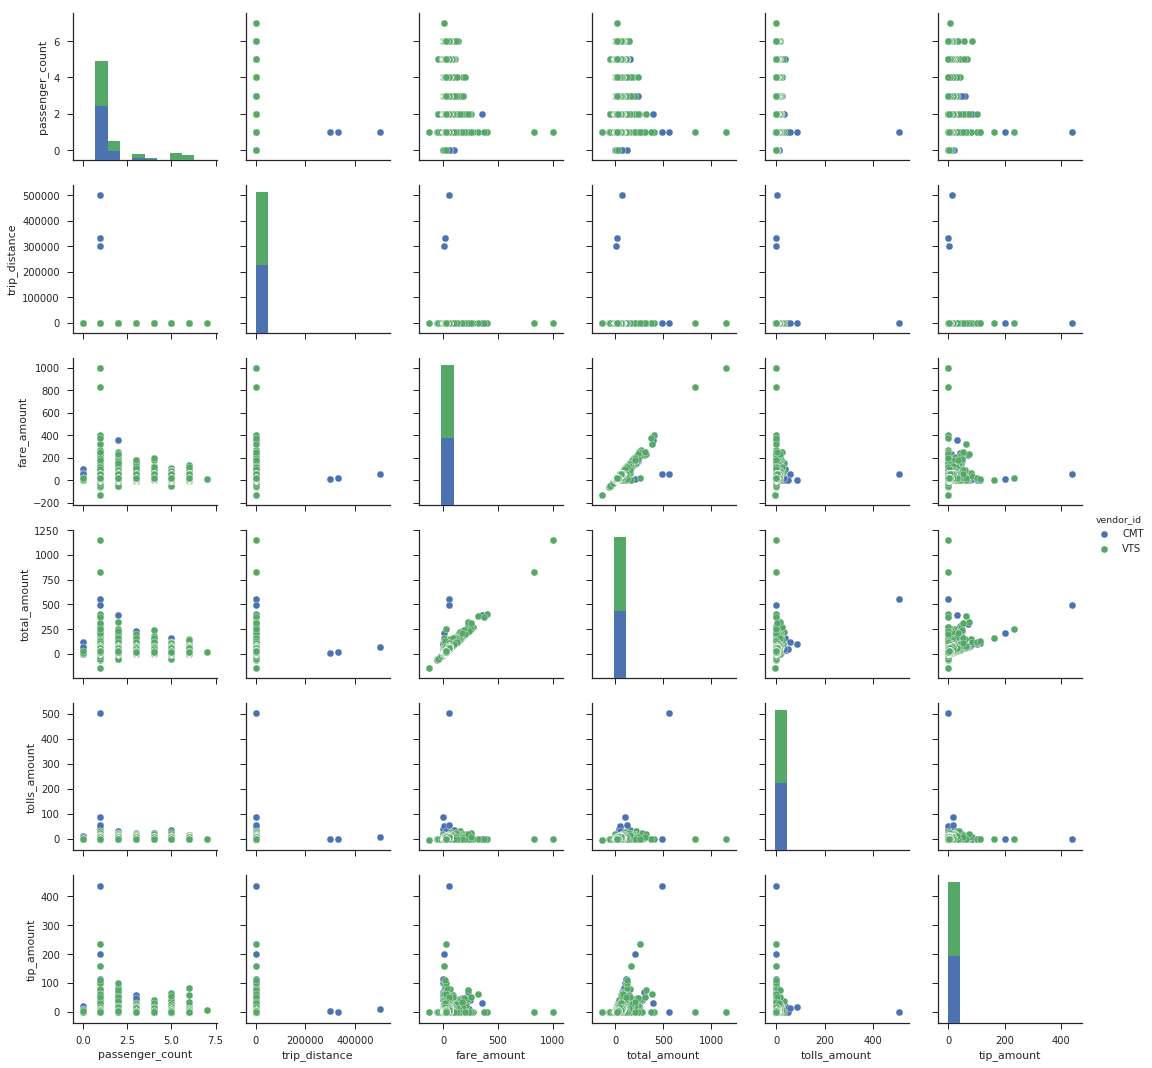

In [93]:
# next look at the non-categorical, non location features
discrete_features = ['passenger_count',
                    'trip_distance',
                    'fare_amount',
                    'total_amount',
                    'tolls_amount',
                    'tip_amount',
                    'vendor_id']

taxi_discrete = taxi_pd.loc[:, discrete_features]

g = sns.pairplot(taxi_discrete, hue="vendor_id")
plt.show()

In [94]:
# fare_amount and total_amount seem to be colinear, so i will not include both of them in the model.  
# conclusions for the other features are limited b/c of signficant outliers.  
# trip_distance appears to have some significant outliers making it difficult to interpret the plot 
# also tip_amount and tolls_amount and total_amount have outliers.  lets look at these features in more detail. 

print 'tip_amount:  \n', taxi_pd['tip_amount'].describe()
print '\n trip_distance:  \n', taxi_pd['trip_distance'].describe()
print '\n tolls_amount:  \n', taxi_pd['tolls_amount'].describe()
print '\n total_amount:  \n', taxi_pd['total_amount'].describe()

tip_amount:  
count    384373.000000
mean          1.674335
std           2.573321
min          -2.700000
25%           0.000000
50%           1.150000
75%           2.260000
max         436.750000
Name: tip_amount, dtype: float64

 trip_distance:  
count    384373.000000
mean          5.868376
std        1083.543794
min           0.000000
25%           1.000000
50%           1.700000
75%           3.170000
max      500000.500000
Name: trip_distance, dtype: float64

 tolls_amount:  
count    384373.000000
mean          0.287135
std           1.572559
min          -5.540000
25%           0.000000
50%           0.000000
75%           0.000000
max         503.830000
Name: tolls_amount, dtype: float64

 total_amount:  
count    384373.000000
mean         15.764573
std          13.241911
min        -139.840000
25%           8.300000
50%          11.800000
75%          17.750000
max        1146.660000
Name: total_amount, dtype: float64


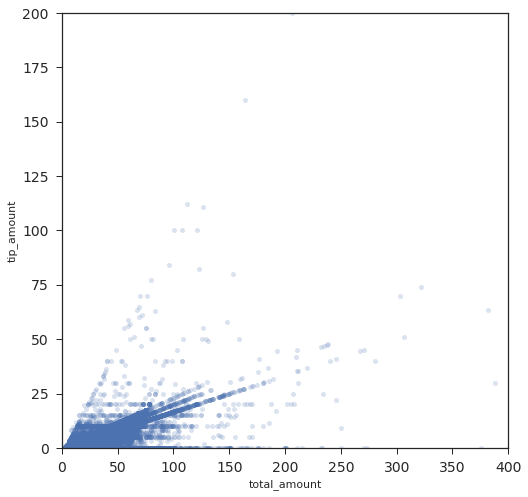

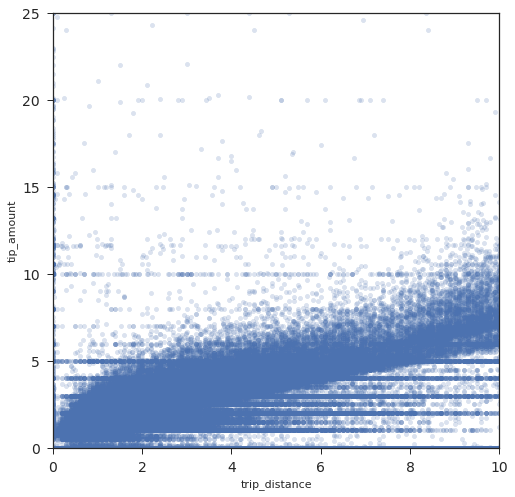

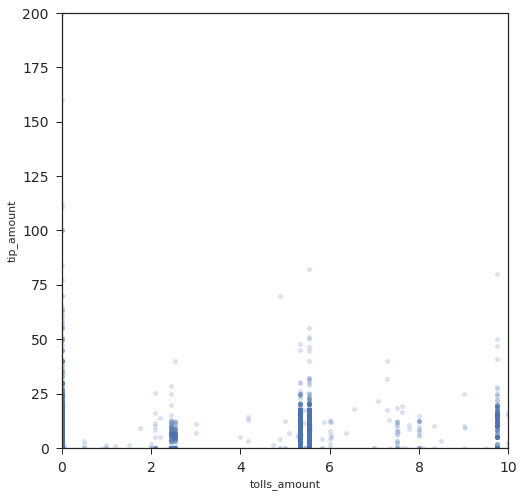

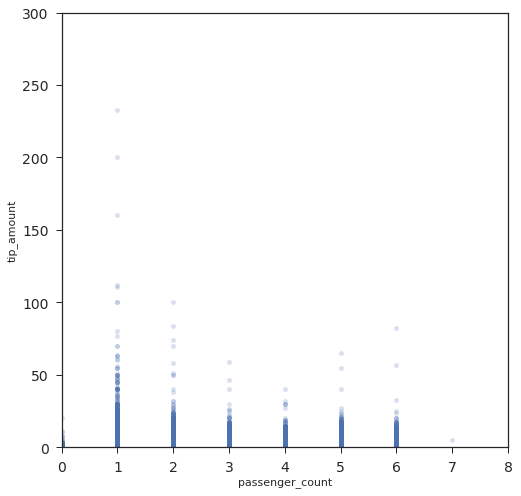

In [108]:
# yikes!  ther are negative toll amounts, zero trip_distance values (missing data?) and negative tip_amounts.
# this data set is a hot mess.  

# plot the above features separately w/ different axis limits to examine the data w/o outliers
taxi_pd.plot.scatter('total_amount', 'tip_amount', alpha=0.2, figsize=(8,8), fontsize=14)
plt.xlim([0,400])
plt.ylim([0,200])
plt.show()

taxi_pd.plot.scatter('trip_distance', 'tip_amount', alpha=0.2, figsize=(8,8), fontsize=14)
plt.xlim([0,10])
plt.ylim([0,25])
plt.show()

taxi_pd.plot.scatter('tolls_amount', 'tip_amount', alpha=0.2, figsize=(8,8), fontsize=14)
plt.xlim([0,10])
plt.ylim([0,200])
plt.show()

taxi_pd.plot.scatter('passenger_count', 'tip_amount', alpha=0.2, figsize=(8,8), fontsize=14)
plt.xlim([0,8])
plt.ylim([0,300])
plt.show()

In [115]:
# as shown above total_amount and trip_distance and passenger appear to have a linear (maybe?) relationship with tip_amount
# so these will be included in the model.
# also, most of the toll_amount values are zero so we will remove this from the model. 
# in summary, we will include the following discrete features in the model:   
#   trip_distance, total_amount, passenger_count

In [121]:
# next we evalute the categorial data:
def unique_snowflakes(feature):
    uniques = taxi_pd[feature].unique()
    print '\nfeature', feature
    for i in uniques:
        name = i.split('u')[0]
        print 'features:  ', name, ' - # of observations:  ', taxi_pd[taxi_pd[feature] == name].shape[0]
    
cats = ['payment_type', 'store_and_fwd_flag']
for i in cats:
    unique_snowflakes(i)


feature payment_type
features:   CRD  - # of observations:   240683
features:   CSH  - # of observations:   142020
features:   DIS  - # of observations:   440
features:   NOC  - # of observations:   1230

feature store_and_fwd_flag
features:   N  - # of observations:   381033
features:   Y  - # of observations:   3340


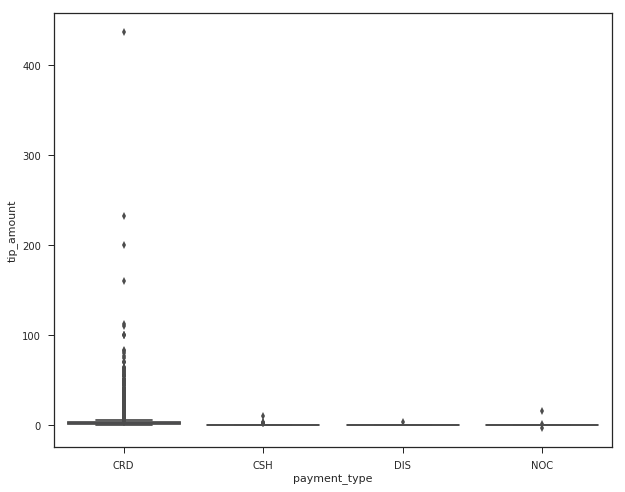

In [145]:
# the majority of the the payments are either crd or csh (card or cash?)
# also, 99.1% of the store_and_fwd_flag features are 'N', so we will not use this features.
# lets determine if payment type and tip_amount are related

sns.boxplot(x='payment_type', y='tip_amount', data=taxi_pd);
plt.rcParams['figure.figsize']=(10,8)
plt.show()

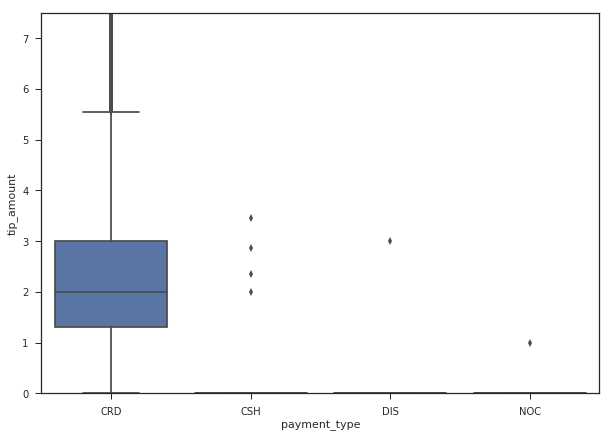

In [148]:
# hard to see anything b/c of outliers.  zoom in.
sns.boxplot(x='payment_type', y='tip_amount', data=taxi_pd);
plt.rcParams['figure.figsize']=(10,8)
plt.ylim([0,7.5])
plt.show()

In [150]:
# people seem to tip quite a bit more when they pay with card.
taxi_pd.groupby('payment_type')['tip_amount'].mean()

payment_type
CRD    2.673771
CSH    0.000146
DIS    0.006818
NOC    0.011439
Name: tip_amount, dtype: float64

In [17]:
# payment type will certainly be included in our model!
# finally we turn to the date.  date formats are painful, so i will practice with a small
# chunk of the spark dataframe (2 rows, to be exact)

taxi_small = taxi.limit(2)
taxi_small.show()

+---------+--------------------+--------------------+------------------+-----------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+
|vendor_id|     pickup_datetime|    dropoff_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|rate_code|passenger_count|trip_distance|payment_type|fare_amount|extra|mta_tax|imp_surcharge|tip_amount|tolls_amount|total_amount|store_and_fwd_flag|
+---------+--------------------+--------------------+------------------+-----------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+
|      CMT|2015-04-30 16:30:...|2015-04-30 17:41:...|-73.78235626220703|40.64461135864258|-73.88793182373047|40.874080657958984|        1|              1|         22.

In [22]:
# there are two date components:  pickup_datetime and dropoff_datetime
taxi_small.select('pickup_datetime').show()

taxi_small.select('dropoff_datetime').show()

+--------------------+
|     pickup_datetime|
+--------------------+
|2015-04-30 16:30:...|
|2015-05-21 07:43:...|
+--------------------+

+--------------------+
|    dropoff_datetime|
+--------------------+
|2015-04-30 17:41:...|
|2015-05-21 08:21:...|
+--------------------+



In [3]:
# write a udf to extract day of the week (dow) from the pickup dates
def dates_are_painful(stripper):
    day, time, timezone = stripper.strip().split()
    return ' '.join([day, time])

udf_myFunction = udf(dates_are_painful)
taxi_dow = taxi_sample.withColumn("pickup_udf", udf_myFunction("pickup_datetime").cast('timestamp'))
taxi_dow2 = taxi_dow.withColumn('dow', date_format('pickup_udf', 'E'))

In [107]:
taxi_dow2_pd = taxi_dow2.toPandas()

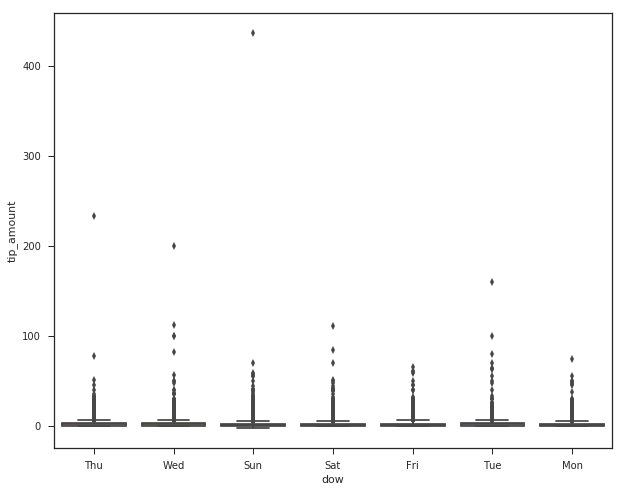

In [109]:
sns.boxplot(x='dow', y='tip_amount', data=taxi_dow2_pd);
plt.rcParams['figure.figsize']=(10,8)
plt.show()

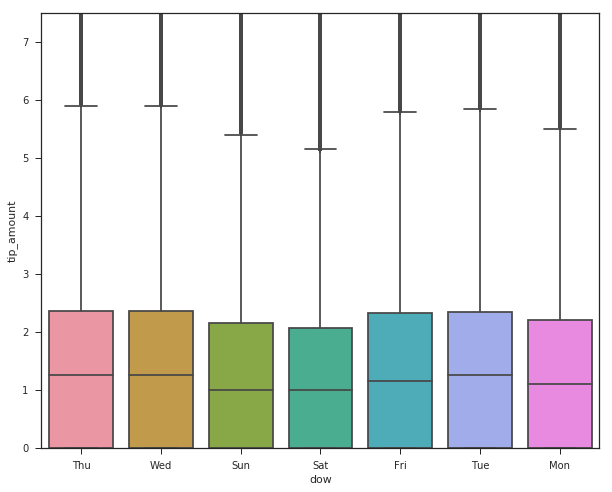

In [110]:
# zoom in for a better view
sns.boxplot(x='dow', y='tip_amount', data=taxi_dow2_pd);
plt.rcParams['figure.figsize']=(10,8)
plt.ylim([0,7.5])
plt.show()

In [112]:
# calculate the summary statistics
print('mean tip amount:')
taxi_dow2_pd.groupby('dow')['tip_amount'].mean()

mean tip amount:


dow
Fri    1.707431
Mon    1.691568
Sat    1.474892
Sun    1.632957
Thu    1.752927
Tue    1.718385
Wed    1.762933
Name: tip_amount, dtype: float64

In [113]:
print('mean tip amount:')
taxi_dow2_pd.groupby('dow')['tip_amount'].median()

mean tip amount:


dow
Fri    1.16
Mon    1.10
Sat    1.00
Sun    1.00
Thu    1.25
Tue    1.25
Wed    1.26
Name: tip_amount, dtype: float64

In [127]:
# Saturday and Suday have the lowest mean and median tip_amounts.  Of the cateogorical values
# we will include payment_type and dow as variables.  We are now ready to format the full data 
# set for model building.  
# But first, we need to transform our data via one-hot encoding. again, practice with the small snippet of data

# first, convert payment type to a numeric index
payment_indexer = StringIndexer(inputCol='payment_type', outputCol='payment_typeIndex')
payment_model = payment_indexer.fit(taxi_sample)
payment_indexed = payment_model.transform(taxi_sample)
payment_indexed

DataFrame[vendor_id: string, pickup_datetime: string, dropoff_datetime: string, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, rate_code: int, passenger_count: int, trip_distance: double, payment_type: string, fare_amount: double, extra: double, mta_tax: double, imp_surcharge: double, tip_amount: double, tolls_amount: double, total_amount: double, store_and_fwd_flag: string, payment_typeIndex: double]

In [128]:
# next, one hot encode the indexed payment_type
payment_encoder = OneHotEncoder(inputCol='payment_typeIndex', outputCol='paymentVec')
payment_encoded = payment_encoder.transform(payment_indexed)
payment_encoded.show()

+---------+--------------------+--------------------+------------------+------------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+-----------------+-------------+
|vendor_id|     pickup_datetime|    dropoff_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|rate_code|passenger_count|trip_distance|payment_type|fare_amount|extra|mta_tax|imp_surcharge|tip_amount|tolls_amount|total_amount|store_and_fwd_flag|payment_typeIndex|   paymentVec|
+---------+--------------------+--------------------+------------------+------------------+------------------+------------------+---------+---------------+-------------+------------+-----------+-----+-------+-------------+----------+------------+------------+------------------+-----------------+-------------+
|      CMT|2015-02-12 11:35:...|2015-02-12 12:10:...|-74.0044708251

In [4]:
# beautiful!  (not really).  now we can one hot encode the entire original dataframe.
# we will use the following features to build our model:
# numeric:  trip_distance, total_amount, passenger_count
# categorical:  payment_type, pickup day of week (calculated from pickup_datetime)

# so, we will select just these features from our original data
taxi_features = taxi.select('trip_distance',
                            'total_amount',
                            'passenger_count',
                            'payment_type',
                            'pickup_datetime', 
                            'tip_amount')

taxi_features.show()

+-------------+------------+---------------+------------+--------------------+----------+
|trip_distance|total_amount|passenger_count|payment_type|     pickup_datetime|tip_amount|
+-------------+------------+---------------+------------+--------------------+----------+
|         22.8|       84.34|              1|         CRD|2015-04-30 16:30:...|       7.0|
|         8.76|       47.81|              1|         CRD|2015-05-21 07:43:...|      7.97|
|         5.17|       32.76|              1|         CRD|2015-05-16 19:41:...|      5.46|
|          5.9|       32.88|              1|         CRD|2015-05-06 00:41:...|      6.58|
|          8.8|       42.41|              1|         CRD|2015-03-27 22:25:...|      7.07|
|          7.5|       32.25|              2|         CRD|2015-03-04 20:29:...|      6.45|
|          6.5|        38.5|              1|         CRD|2015-02-15 18:08:...|       7.7|
|        14.33|       50.76|              1|         CRD|2015-04-27 21:44:...|      8.46|
|        1

In [5]:
# next, extract day of week from pickup_datetime
taxi_dow = taxi_features.withColumn("pickup_udf", udf_myFunction("pickup_datetime").cast('timestamp'))
taxi_dowE = taxi_dow.withColumn('dow', date_format('pickup_udf', 'E'))
taxi_dowE.show()

+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+
|trip_distance|total_amount|passenger_count|payment_type|     pickup_datetime|tip_amount|          pickup_udf|dow|
+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+
|         22.8|       84.34|              1|         CRD|2015-04-30 16:30:...|       7.0|2015-04-30 16:30:...|Thu|
|         8.76|       47.81|              1|         CRD|2015-05-21 07:43:...|      7.97|2015-05-21 07:43:...|Thu|
|         5.17|       32.76|              1|         CRD|2015-05-16 19:41:...|      5.46|2015-05-16 19:41:...|Sat|
|          5.9|       32.88|              1|         CRD|2015-05-06 00:41:...|      6.58|2015-05-06 00:41:...|Wed|
|          8.8|       42.41|              1|         CRD|2015-03-27 22:25:...|      7.07|2015-03-27 22:25:...|Fri|
|          7.5|       32.25|              2|         CRD|2015-03-04 20:29:...|  

In [6]:
# one hot encode payment type
payment_indexer = StringIndexer(inputCol='payment_type', outputCol='payment_typeIndex')
payment_model = payment_indexer.fit(taxi_dowE)
payment_indexed = payment_model.transform(taxi_dowE)

payment_encoder = OneHotEncoder(inputCol='payment_typeIndex', outputCol='paymentVec')
payment_encoded = payment_encoder.transform(payment_indexed)
payment_encoded.show()

+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+-----------------+-------------+
|trip_distance|total_amount|passenger_count|payment_type|     pickup_datetime|tip_amount|          pickup_udf|dow|payment_typeIndex|   paymentVec|
+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+-----------------+-------------+
|         22.8|       84.34|              1|         CRD|2015-04-30 16:30:...|       7.0|2015-04-30 16:30:...|Thu|              0.0|(4,[0],[1.0])|
|         8.76|       47.81|              1|         CRD|2015-05-21 07:43:...|      7.97|2015-05-21 07:43:...|Thu|              0.0|(4,[0],[1.0])|
|         5.17|       32.76|              1|         CRD|2015-05-16 19:41:...|      5.46|2015-05-16 19:41:...|Sat|              0.0|(4,[0],[1.0])|
|          5.9|       32.88|              1|         CRD|2015-05-06 00:41:...|      6.58|2015-05-06 00:41:...|Wed|    

In [7]:
# one hot encode pickup day of week
dow_indexer = StringIndexer(inputCol='dow', outputCol='dowIndex')
dow_model = dow_indexer.fit(payment_encoded)
dow_indexed = dow_model.transform(payment_encoded)

dow_encoder = OneHotEncoder(inputCol='dowIndex', outputCol='dowVec')
dow_payment_encoded = dow_encoder.transform(dow_indexed)
dow_payment_encoded.show()

+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+-----------------+-------------+--------+-------------+
|trip_distance|total_amount|passenger_count|payment_type|     pickup_datetime|tip_amount|          pickup_udf|dow|payment_typeIndex|   paymentVec|dowIndex|       dowVec|
+-------------+------------+---------------+------------+--------------------+----------+--------------------+---+-----------------+-------------+--------+-------------+
|         22.8|       84.34|              1|         CRD|2015-04-30 16:30:...|       7.0|2015-04-30 16:30:...|Thu|              0.0|(4,[0],[1.0])|     2.0|(6,[2],[1.0])|
|         8.76|       47.81|              1|         CRD|2015-05-21 07:43:...|      7.97|2015-05-21 07:43:...|Thu|              0.0|(4,[0],[1.0])|     2.0|(6,[2],[1.0])|
|         5.17|       32.76|              1|         CRD|2015-05-16 19:41:...|      5.46|2015-05-16 19:41:...|Sat|              0.0|(4,[0],[1.0])|    

In [8]:
# select only the features that we need moving forward
taxi_final = dow_payment_encoded.select('trip_distance',
                                        'total_amount',
                                        'passenger_count',
                                        'dowVec',
                                        'paymentVec', 
                                        'tip_amount')

taxi_final.show()

+-------------+------------+---------------+-------------+-------------+----------+
|trip_distance|total_amount|passenger_count|       dowVec|   paymentVec|tip_amount|
+-------------+------------+---------------+-------------+-------------+----------+
|         22.8|       84.34|              1|(6,[2],[1.0])|(4,[0],[1.0])|       7.0|
|         8.76|       47.81|              1|(6,[2],[1.0])|(4,[0],[1.0])|      7.97|
|         5.17|       32.76|              1|(6,[0],[1.0])|(4,[0],[1.0])|      5.46|
|          5.9|       32.88|              1|(6,[3],[1.0])|(4,[0],[1.0])|      6.58|
|          8.8|       42.41|              1|(6,[1],[1.0])|(4,[0],[1.0])|      7.07|
|          7.5|       32.25|              2|(6,[3],[1.0])|(4,[0],[1.0])|      6.45|
|          6.5|        38.5|              1|(6,[5],[1.0])|(4,[0],[1.0])|       7.7|
|        14.33|       50.76|              1|    (6,[],[])|(4,[0],[1.0])|      8.46|
|        12.71|       50.34|              1|(6,[5],[1.0])|(4,[0],[1.0])|    

### Model Building

In [9]:
# now we build a linear regression model to predict tip amount from the features we have created
feature_cols = ['trip_distance', 'total_amount', 'passenger_count', 'dowVec', 'paymentVec']
label_col = 'tip_amount'

# vector assembler to build a dense vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

In [10]:
# Reduce dataframe to essential columns for model building
taxi_xform = assembler.transform(
    taxi_final.select(feature_cols + [label_col]))
taxi_xform.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- dowVec: vector (nullable = true)
 |-- paymentVec: vector (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- features: vector (nullable = true)



In [11]:
taxi_xform.show()

+-------------+------------+---------------+-------------+-------------+----------+--------------------+
|trip_distance|total_amount|passenger_count|       dowVec|   paymentVec|tip_amount|            features|
+-------------+------------+---------------+-------------+-------------+----------+--------------------+
|         22.8|       84.34|              1|(6,[2],[1.0])|(4,[0],[1.0])|       7.0|(13,[0,1,2,5,9],[...|
|         8.76|       47.81|              1|(6,[2],[1.0])|(4,[0],[1.0])|      7.97|(13,[0,1,2,5,9],[...|
|         5.17|       32.76|              1|(6,[0],[1.0])|(4,[0],[1.0])|      5.46|(13,[0,1,2,3,9],[...|
|          5.9|       32.88|              1|(6,[3],[1.0])|(4,[0],[1.0])|      6.58|(13,[0,1,2,6,9],[...|
|          8.8|       42.41|              1|(6,[1],[1.0])|(4,[0],[1.0])|      7.07|(13,[0,1,2,4,9],[...|
|          7.5|       32.25|              2|(6,[3],[1.0])|(4,[0],[1.0])|      6.45|(13,[0,1,2,6,9],[...|
|          6.5|        38.5|              1|(6,[5],[1.0

In [12]:
taxi_xform.count()

77106102

In [13]:
# build LR model
taxi_train = taxi_xform.withColumnRenamed('tip_amount', 'label').select('label', 'features')
taxi_train

DataFrame[label: double, features: vector]

In [14]:
taxi_train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  7.0|(13,[0,1,2,5,9],[...|
| 7.97|(13,[0,1,2,5,9],[...|
| 5.46|(13,[0,1,2,3,9],[...|
| 6.58|(13,[0,1,2,6,9],[...|
| 7.07|(13,[0,1,2,4,9],[...|
| 6.45|(13,[0,1,2,6,9],[...|
|  7.7|(13,[0,1,2,8,9],[...|
| 8.46|(13,[0,1,2,9],[14...|
|  7.0|(13,[0,1,2,8,9],[...|
| 4.55|(13,[0,1,2,5,9],[...|
| 8.96|(13,[0,1,2,5,9],[...|
| 4.66|(13,[0,1,2,9],[7....|
| 4.75|(13,[0,1,2,3,9],[...|
|  3.2|(13,[0,1,2,9],[8....|
| 6.95|(13,[0,1,2,6,9],[...|
| 0.86|(13,[0,1,2,5,9],[...|
| 4.95|(13,[0,1,2,7,9],[...|
| 5.45|(13,[0,1,2,8,9],[...|
| 9.25|(13,[0,1,2,7,9],[...|
| 5.35|(13,[0,1,2,8,9],[...|
+-----+--------------------+
only showing top 20 rows



In [15]:
# split into test/train sets
taxi_full_train, taxi_full_test = taxi_train.randomSplit([0.5, 0.5])
taxi_full_train.count(), taxi_full_test.count()

(38549997, 38556105)

In [16]:
# fit the model to the data
start_time = time.time()
lr = pyspark.ml.regression.LinearRegression(maxIter=1)
lrmodel = lr.fit(taxi_full_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2643.78178501 seconds ---


In [17]:
# make predictions
taxi_pred = lrmodel.transform(taxi_full_test)
taxi_pred

DataFrame[label: double, features: vector, prediction: double]

In [18]:
# show a few predictions
taxi_pred.show(3)

+-----+--------------------+-------------------+
|label|            features|         prediction|
+-----+--------------------+-------------------+
|-22.0|(13,[0,1,2,6,9],[...|-39.454012044818235|
|-8.38|(13,[1,2,4,12],[-...|-47.850228267692884|
| -2.0|(13,[1,2,8,9],[-3...| -42.14938129639681|
+-----+--------------------+-------------------+
only showing top 3 rows



In [19]:
# model coefficients
lrmodel.coefficients, lrmodel.intercept

(DenseVector([-0.0, 0.9425, -0.136, 0.8535, -0.0964, -0.1347, 0.0465, 0.1381, -0.01, -6.9313, -5.567, -9.2002, -6.693]),
 -6.703676649499418)

In [20]:
# print those normally distrubuted about zero residuals
lrmodel.summary.residuals.agg({'residuals': 'avg'}).show()

+--------------------+
|      avg(residuals)|
+--------------------+
|-2.28915603625789...|
+--------------------+



In [21]:
lrmodel.summary.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|  31.17604346755676|
| 18.976969138579076|
|  19.50466535224753|
|  23.16335065356887|
| 20.832809886429228|
| 18.239540297490333|
| 19.046577260806114|
| 18.954998029275703|
| 19.103037161345245|
| 19.103037161345245|
| 19.576574569424224|
| 19.576574569424224|
| 18.253346867188256|
|     7.929239629308|
|  9.336062621162627|
|-11.398335156527583|
| -58.38599783304357|
|  9.336063058740276|
| -43.91364010608438|
|  9.943268664652356|
+-------------------+
only showing top 20 rows



In [22]:
# how much variance in the response variable is predicted by the independent variables?
lrmodel.summary.r2

0.9425097774213026

In [ ]:
# get a snipped of the predictions for visualization

In [25]:
pred_sample = taxi_pred.sample(withReplacement=False, fraction=0.005, seed=123)
pred_pd = pred_sample.toPandas()

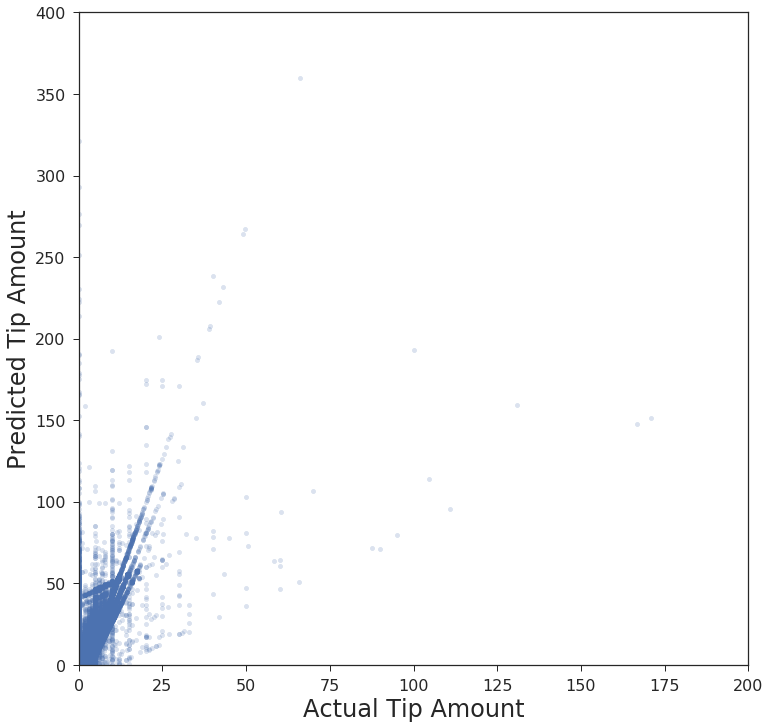

In [52]:
# visualize predictions versus actual
pred_pd.plot.scatter('label', 'prediction', figsize=(12, 12), fontsize=16, alpha=0.2)
plt.xlabel('Actual Tip Amount', fontsize=24)
plt.ylabel('Predicted Tip Amount', fontsize=24)
plt.xlim([0,200])
plt.ylim([0,400])
plt.show()

In [40]:
# plot the residuals
pred_pd['residual'] = pred_pd['prediction'] - pred_pd['label']

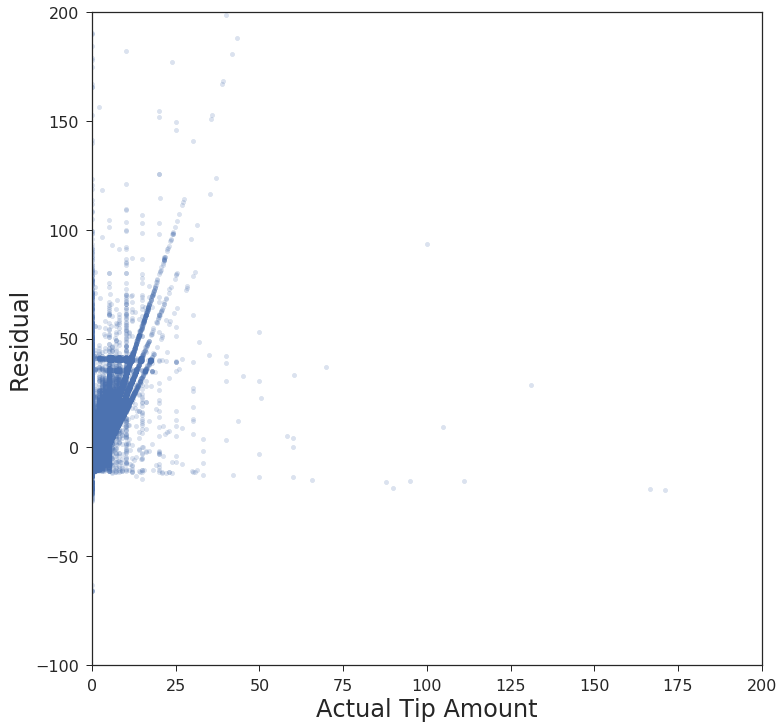

In [51]:
pred_pd.plot.scatter('label', 'residual', figsize=(12, 12), fontsize=16, alpha=0.2)
plt.xlabel('Actual Tip Amount', fontsize=24)
plt.ylabel('Residual', fontsize=24)
plt.xlim([0,200])
plt.ylim([-100,200])
plt.show()

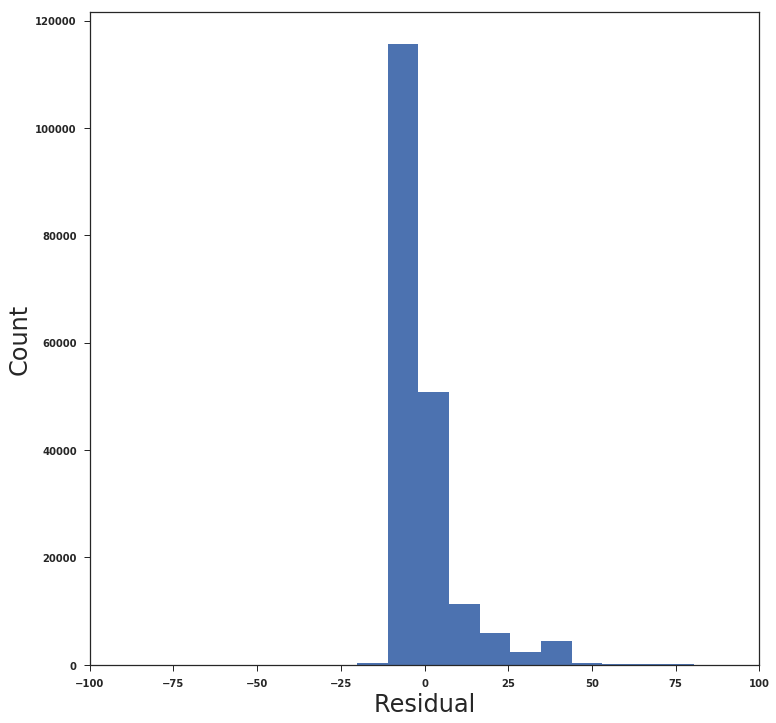

In [68]:
# histogram of residuals

font = {'weight' : 'bold',
        'size'   : 24}
    
plt.rc('font', **font)
    
resids = list(pred_pd['residual'])
plt.figure(figsize=(12, 12))

plt.hist(resids, bins=100)
plt.xlabel('Residual', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.xlim([-100, 100])

plt.show()

In [ ]:
# As shown above, the distribution of the residuals is right skewed. 
# This seems to come from the fact that our model predicts a tip when no tip was actually paid.
# Moving forward, we should explore the data deeper and find features or ways to exploit the 
# data to predict when no tip will be paid.  Next time!